In [43]:
#import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import json
import requests
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

#Import libraries for plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (17,8)
plt.style.use('fivethirtyeight')
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#import datetime
from datetime import datetime, timedelta

#import library for ARIMA model implementation
from statsmodels.tsa.arima_model import ARIMA
#library imported for plotting ACG and PACF graphs                 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
#library to compute with ADFuller test
from statsmodels.tsa.stattools import adfuller               

#importing seasonal decompistion
from statsmodels.tsa.seasonal import seasonal_decompose

# import statistics tools
from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [44]:
# Get live data for Bitcoin (BTC)
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday'
response = requests.get(endpoint + '?fsym=BTC&ETH&tsym=USD&limit=1999&api_key=346a5653477eed39d369f3b05523c27a427a45ab31125be8a8dbf06cf4478d49')
df = pd.DataFrame(json.loads(response.content)['Data']['Data'])
df = df.set_index('time','Symbol')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [45]:
df.head(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2017-11-09,7457.12,7040.83,7444.36,126769.90,9.159639e+08,7129.59,direct,
2017-11-10,7318.97,6406.05,7129.59,222001.18,1.513421e+09,6565.80,direct,
2017-11-11,6821.50,6197.87,6565.80,135719.07,8.780969e+08,6339.86,direct,
2017-11-12,6490.53,5493.64,6339.87,269832.87,1.629165e+09,5878.13,direct,
2017-11-13,6760.15,5828.34,5878.09,178340.89,1.135256e+09,6522.45,direct,
2017-11-14,6728.59,6419.18,6522.45,96502.09,6.346050e+08,6597.06,direct,
2017-11-15,7330.06,6596.94,6597.06,131120.23,9.229595e+08,7283.22,direct,
2017-11-16,7964.64,7119.17,7283.02,133937.80,1.010131e+09,7853.68,direct,
2017-11-17,8000.19,7534.70,7853.68,117347.03,9.175999e+08,7699.95,direct,


In [46]:
df.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [47]:
# print first 10
df.head(10)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-11-09,7457.12,7040.83,7444.36,126769.90,9.159639e+08,7129.59
2017-11-10,7318.97,6406.05,7129.59,222001.18,1.513421e+09,6565.80
2017-11-11,6821.50,6197.87,6565.80,135719.07,8.780969e+08,6339.86
2017-11-12,6490.53,5493.64,6339.87,269832.87,1.629165e+09,5878.13
2017-11-13,6760.15,5828.34,5878.09,178340.89,1.135256e+09,6522.45
2017-11-14,6728.59,6419.18,6522.45,96502.09,6.346050e+08,6597.06
2017-11-15,7330.06,6596.94,6597.06,131120.23,9.229595e+08,7283.22
2017-11-16,7964.64,7119.17,7283.02,133937.80,1.010131e+09,7853.68
2017-11-17,8000.19,7534.70,7853.68,117347.03,9.175999e+08,7699.95


In [ ]:
# print last 5
df.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2023-04-27,29891.79,28395.94,28433.41,63311.68,1.849959e+09,29485.09
2023-04-28,29604.84,28922.60,29485.09,35155.43,1.029966e+09,29339.91
2023-04-29,29463.49,29090.83,29339.91,11322.94,3.317918e+08,29250.94
2023-04-30,29963.23,29110.79,29250.94,23236.42,6.854655e+08,29234.41
2023-05-01,29332.00,29234.41,29234.41,1067.61,3.127344e+07,29310.36


In [ ]:
df.describe()

,high,low,open,volumefrom,volumeto,close
count,2000.00000,2000.000000,2000.000000,2000.00000,2.000000e+03,2000.000000
mean,20890.19416,19738.900345,20345.164540,57476.91598,1.019993e+09,20356.079025
std,16794.05578,15851.811806,16356.142672,44753.71994,9.799626e+08,16354.841235
min,3271.76000,3169.530000,3232.510000,1067.61000,3.127344e+07,3232.510000
25%,8199.13500,7748.465000,7978.505000,29840.72500,3.419004e+08,7989.595000
50%,11911.21500,11293.975000,11654.665000,44398.18500,7.241094e+08,11662.470000
75%,31330.69750,29478.397500,30407.255000,68666.63000,1.389337e+09,30407.255000
max,68978.64000,66312.420000,67549.140000,495883.24000,1.112022e+10,67549.140000


In [ ]:
df = df[["close"]].copy()

In [ ]:
df.describe()

,close
count,2000.000000
mean,20356.079025
std,16354.841235
min,3232.510000
25%,7989.595000
50%,11662.470000
75%,30407.255000
max,67549.140000


In [ ]:
#resampling the data into monthly frequency[3]
df_mth = df.resample('M').mean()

Augmented Dickey Fuller(ADF) test result: p = 0.505711 


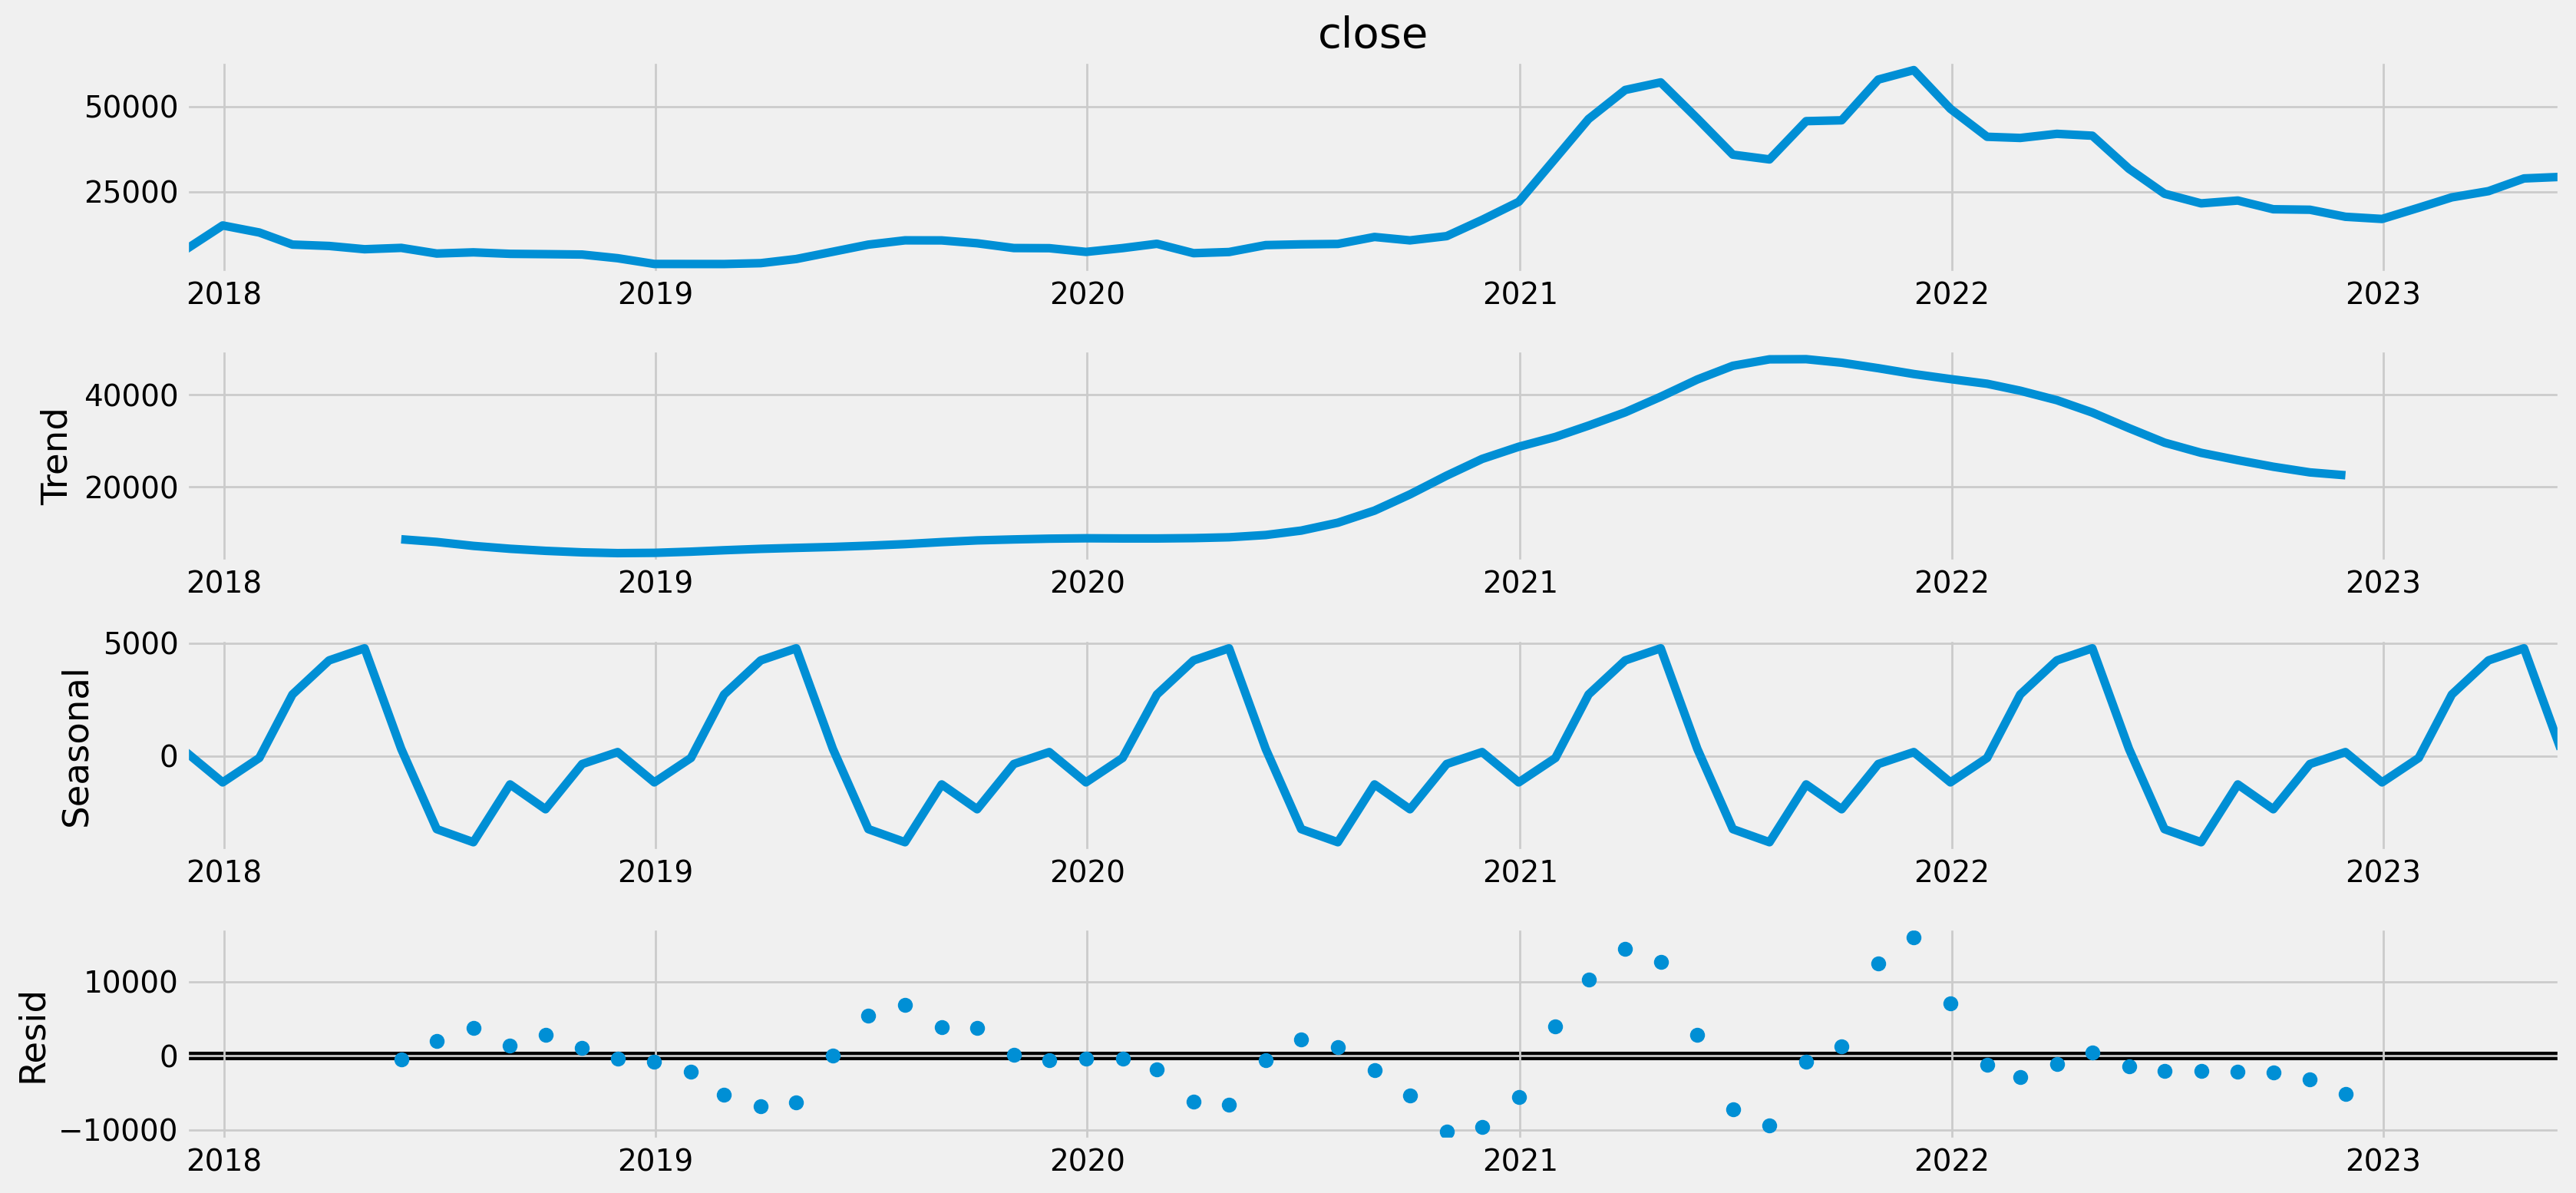

In [ ]:
#will be utilizing it for graphical representation of decomposition
seasonal_decompose(df_mth.close).plot() #[3]
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f " % adfuller(df_mth.close)[1])
plt.show()

In [ ]:
# implementing Box-Cox Transformations for normalization [3]
df_mth['close_box'], lmbda = stats.boxcox(df_mth.close)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p =%f" % adfuller(df_mth.close_box)[1])

Augmented Dickey Fuller(ADF) test result: p =0.687507


In [ ]:
# creating new dataframe to compute monthly seasonal differentition for 12 months [3]
df_mth['box_diff_seasonal_12'] = (df_mth.close_box - df_mth.close_box.shift(12))
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff_seasonal_12[12:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.023315


In [ ]:
#creating new dataframe to compute monthly seasonal differentition for 3 months [3]
df_mth['box_diff_seasonal_3'] = df_mth.close_box - df_mth.close_box.shift(3)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff_seasonal_3[3:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.028869


Augmented Dickey Fuller(ADF) test result: p = 0.000002


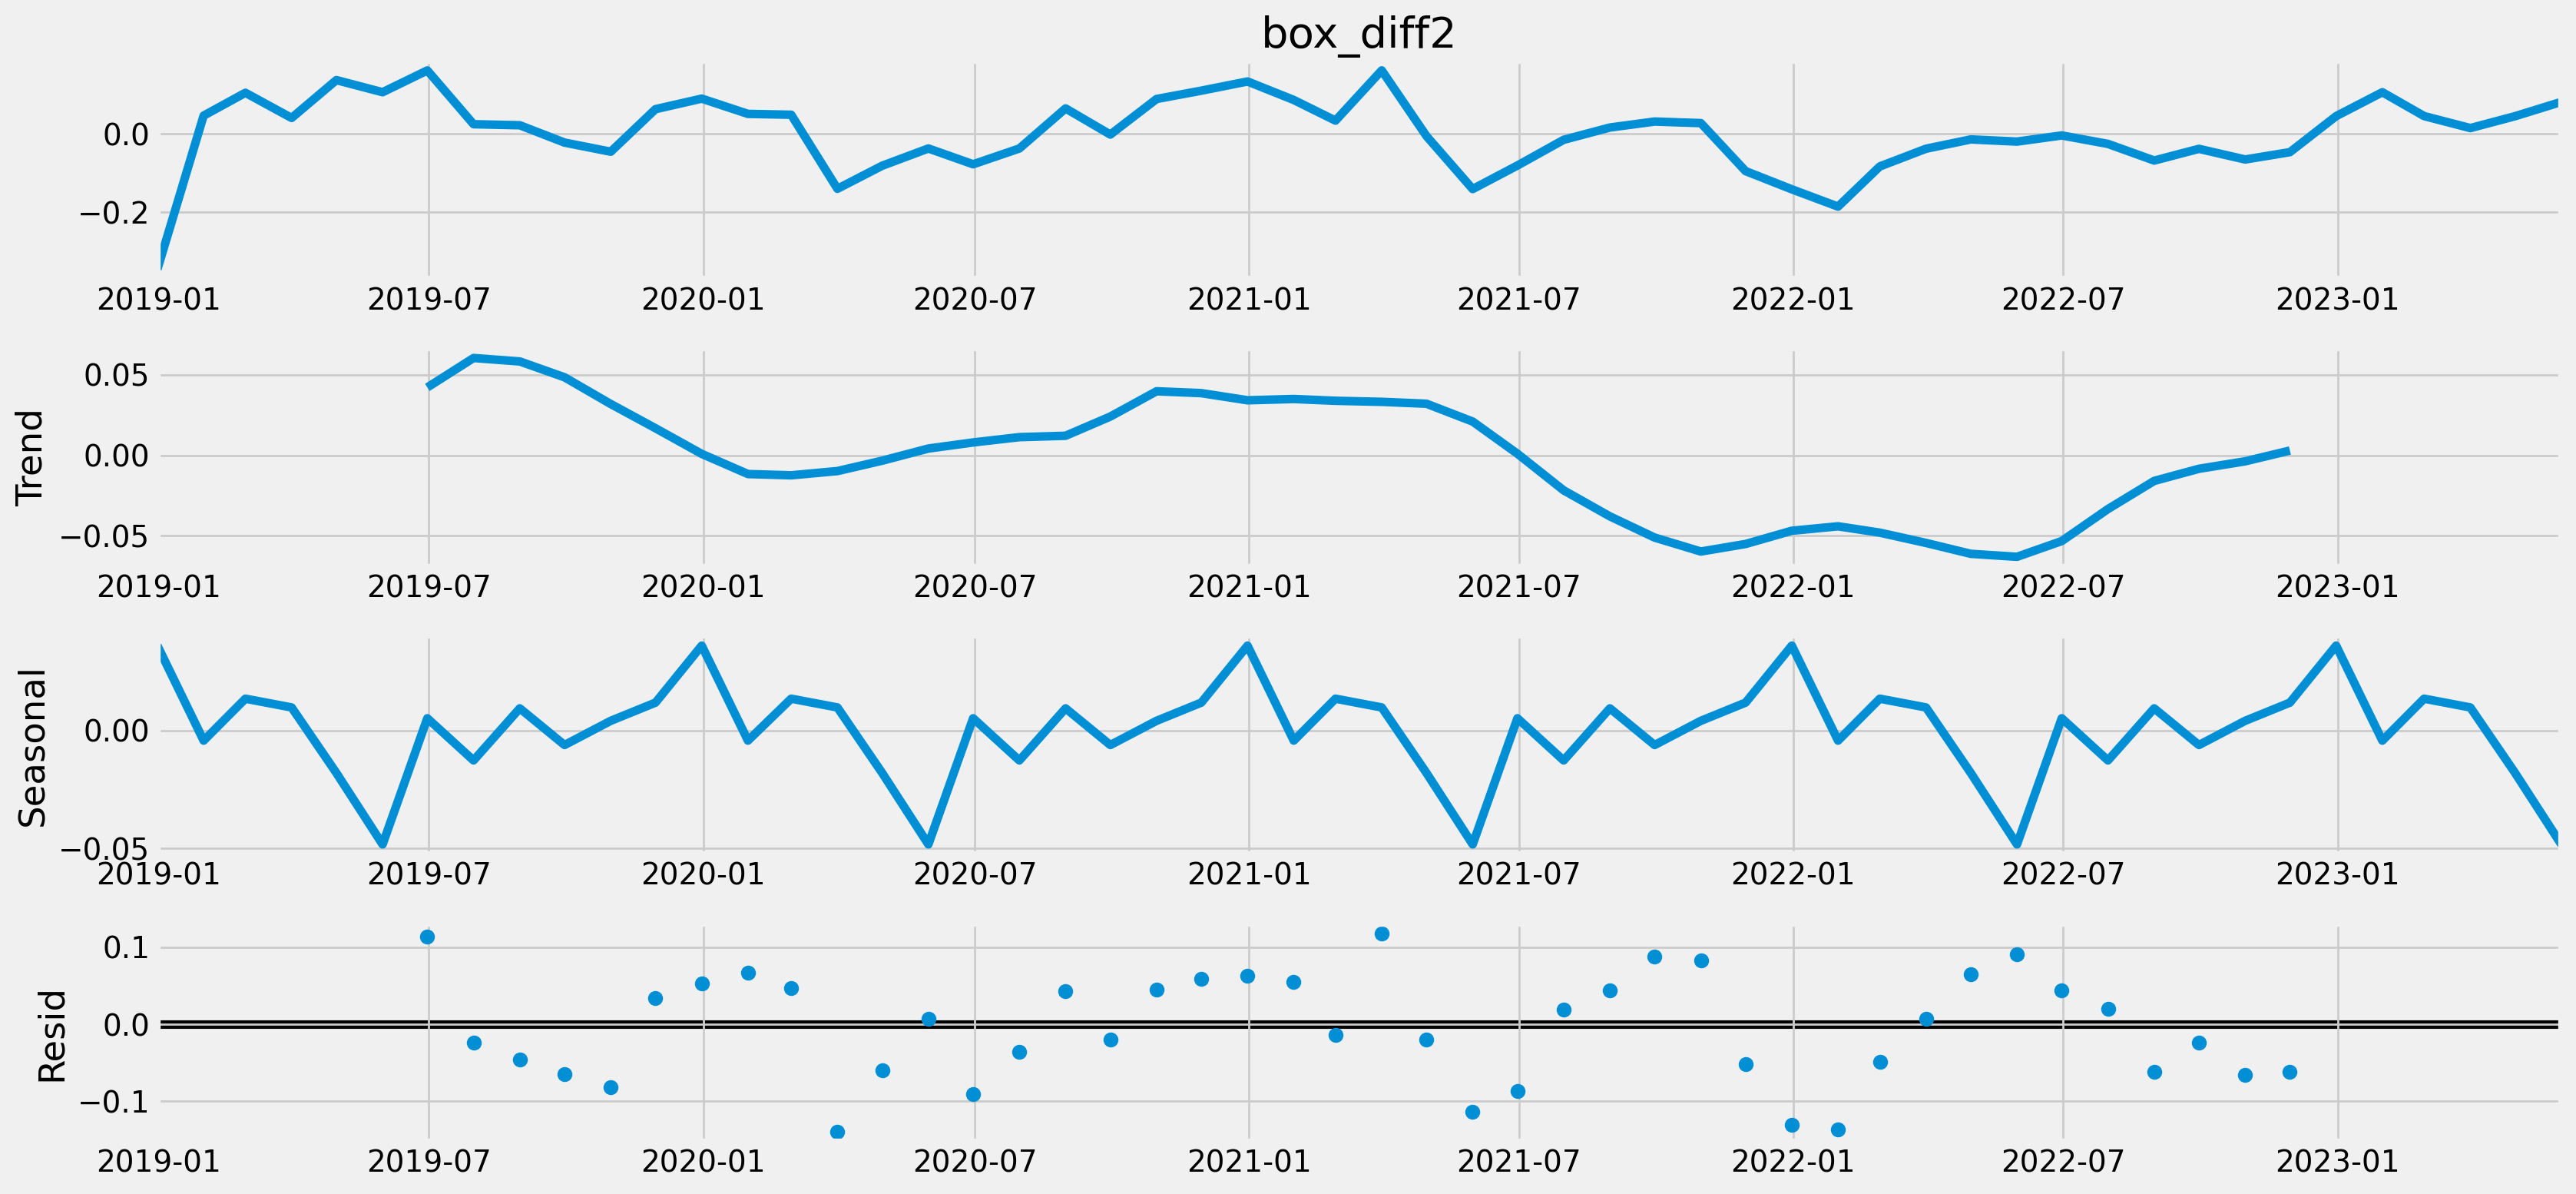

In [ ]:
# #creating new dataframe to compute implement differentition for 12 months [3]
df_mth['box_diff2'] = (df_mth.box_diff_seasonal_12 - df_mth.box_diff_seasonal_12.shift(1))

# Seasonal and Trend decomposition using Loess decomposition [3]
seasonal_decompose(df_mth.box_diff2[13:]).plot()   
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff2[13:])[1])

plt.show()

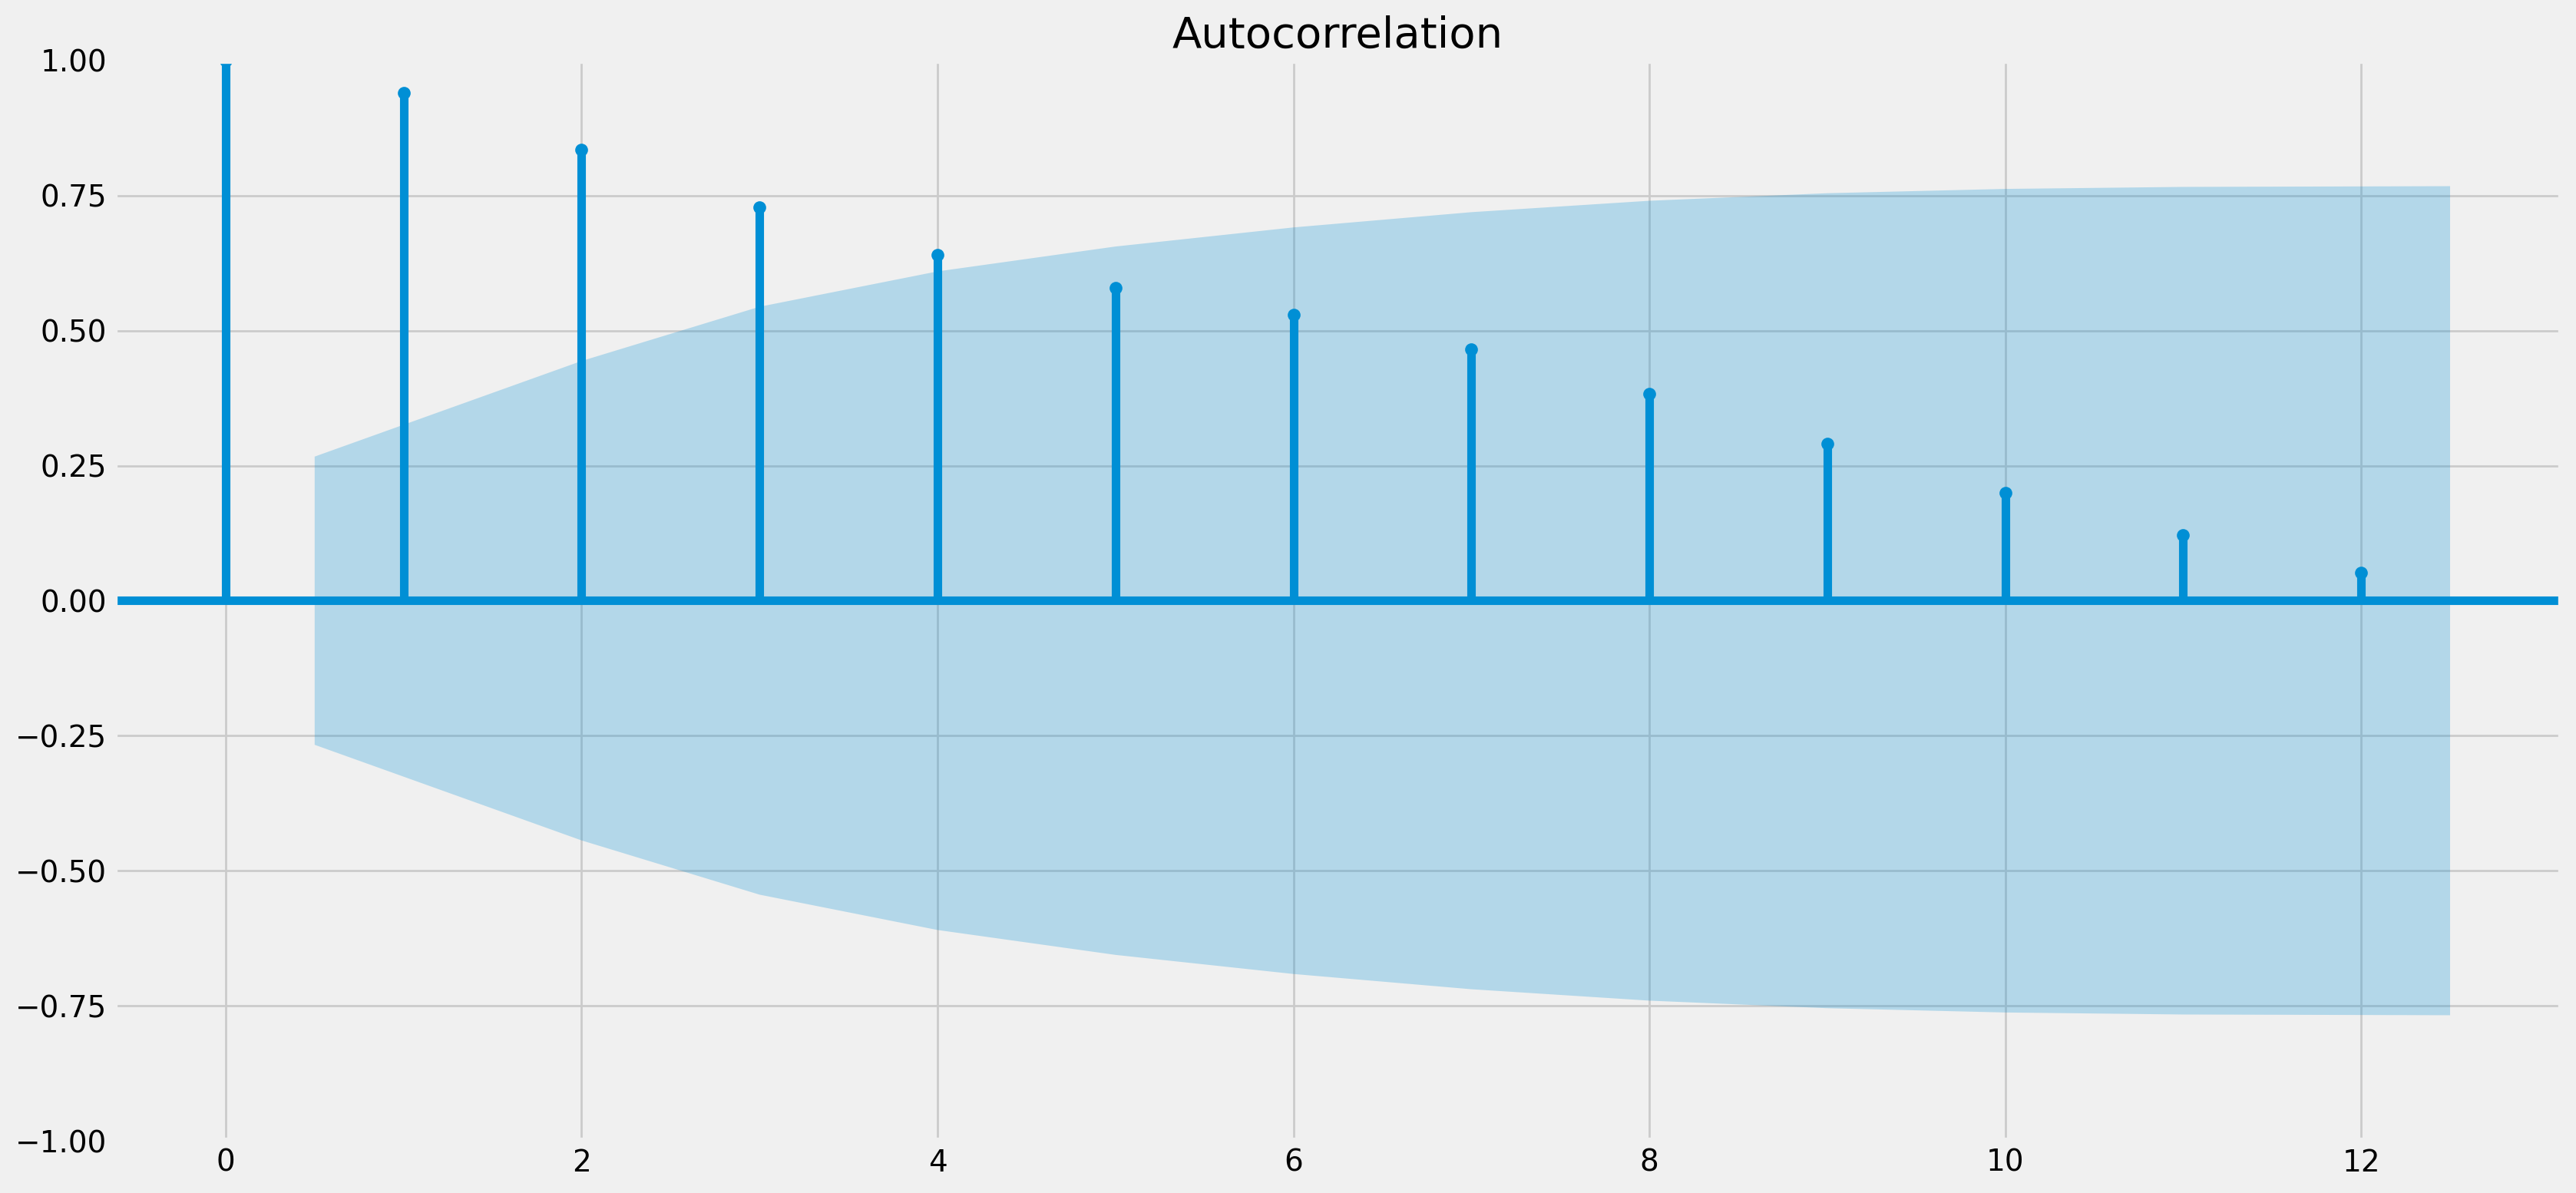

In [ ]:
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_acf(df_mth.close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

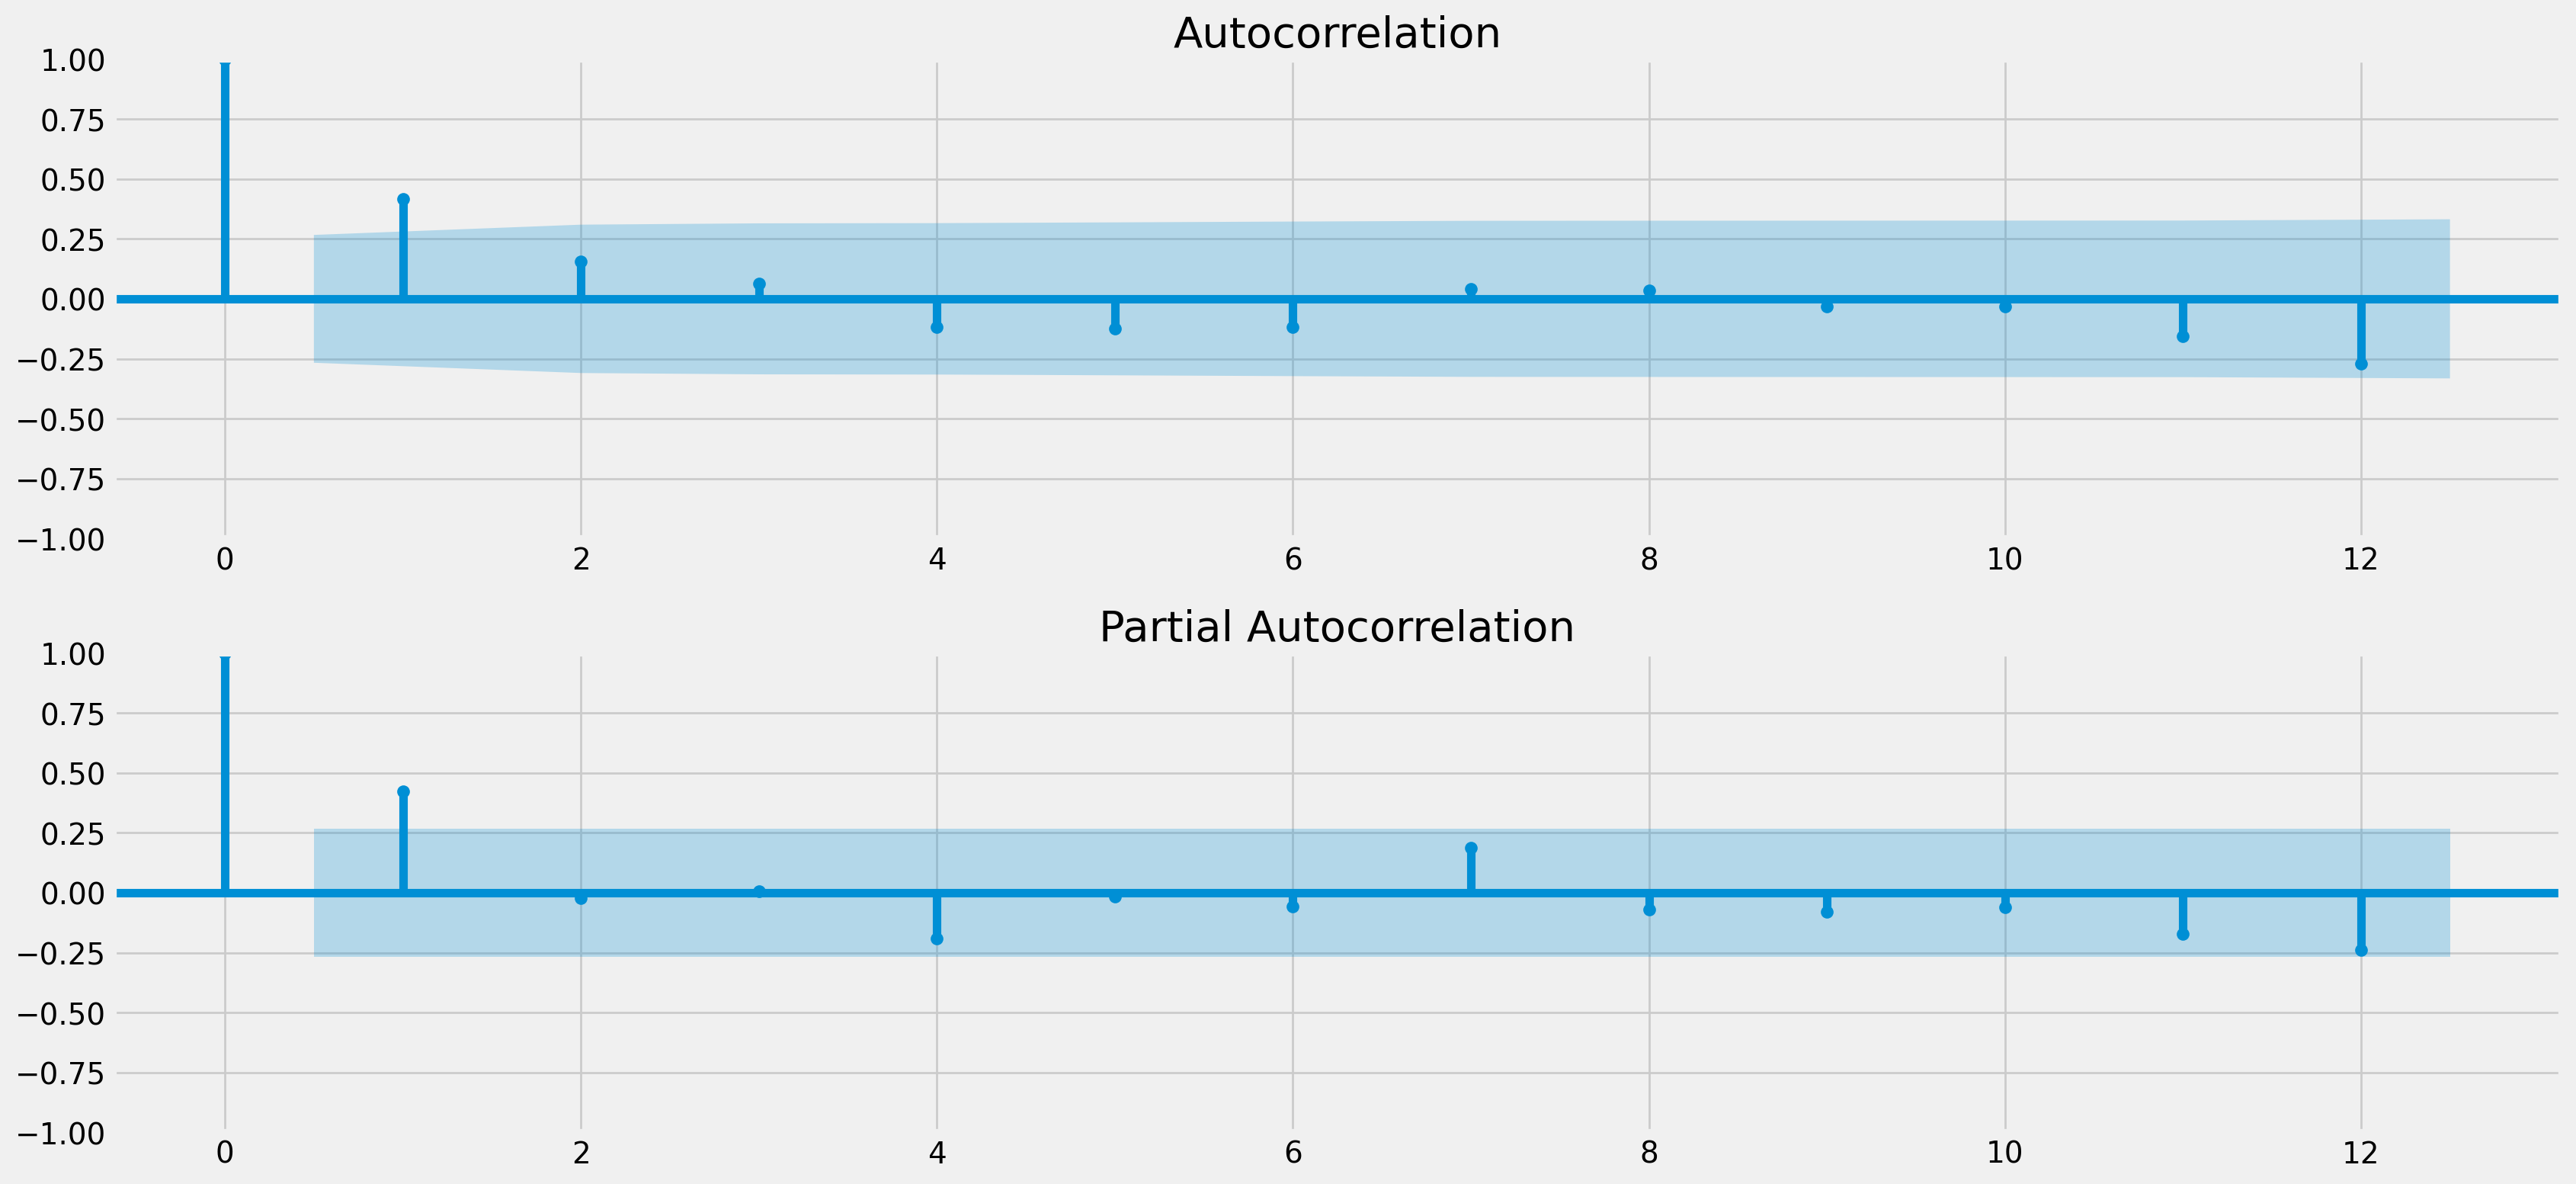

In [ ]:
# Initial parameter approximation 
#PlottingAutocorrelation(ACF) and Partial Autocorrelation(PACF) Plots[3]
ax = plt.subplot(211)
# Plot the autocorrelation function [3]
plot_acf(df_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_pacf(df_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
import statsmodels.api as sm
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
model = sm.tsa.arima.ARIMA(df_mth.close_box, order=(7, 1, 3))
result=model.fit()

In [ ]:
#representation of summary of appropriate ARIMA models[1]
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   67
Model:                 ARIMA(7, 1, 3)   Log Likelihood                  96.730
Date:                Mon, 01 May 2023   AIC                           -171.459
Time:                        00:50:46   BIC                           -147.373
Sample:                    11-30-2017   HQIC                          -161.942
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2171     20.368      0.011      0.991     -39.704      40.138
ar.L2         -0.1036      3.020     -0.034      0.973      -6.022       5.815
ar.L3          0.1516      2.507      0.060      0.9

In [ ]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(result.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p=0.000000


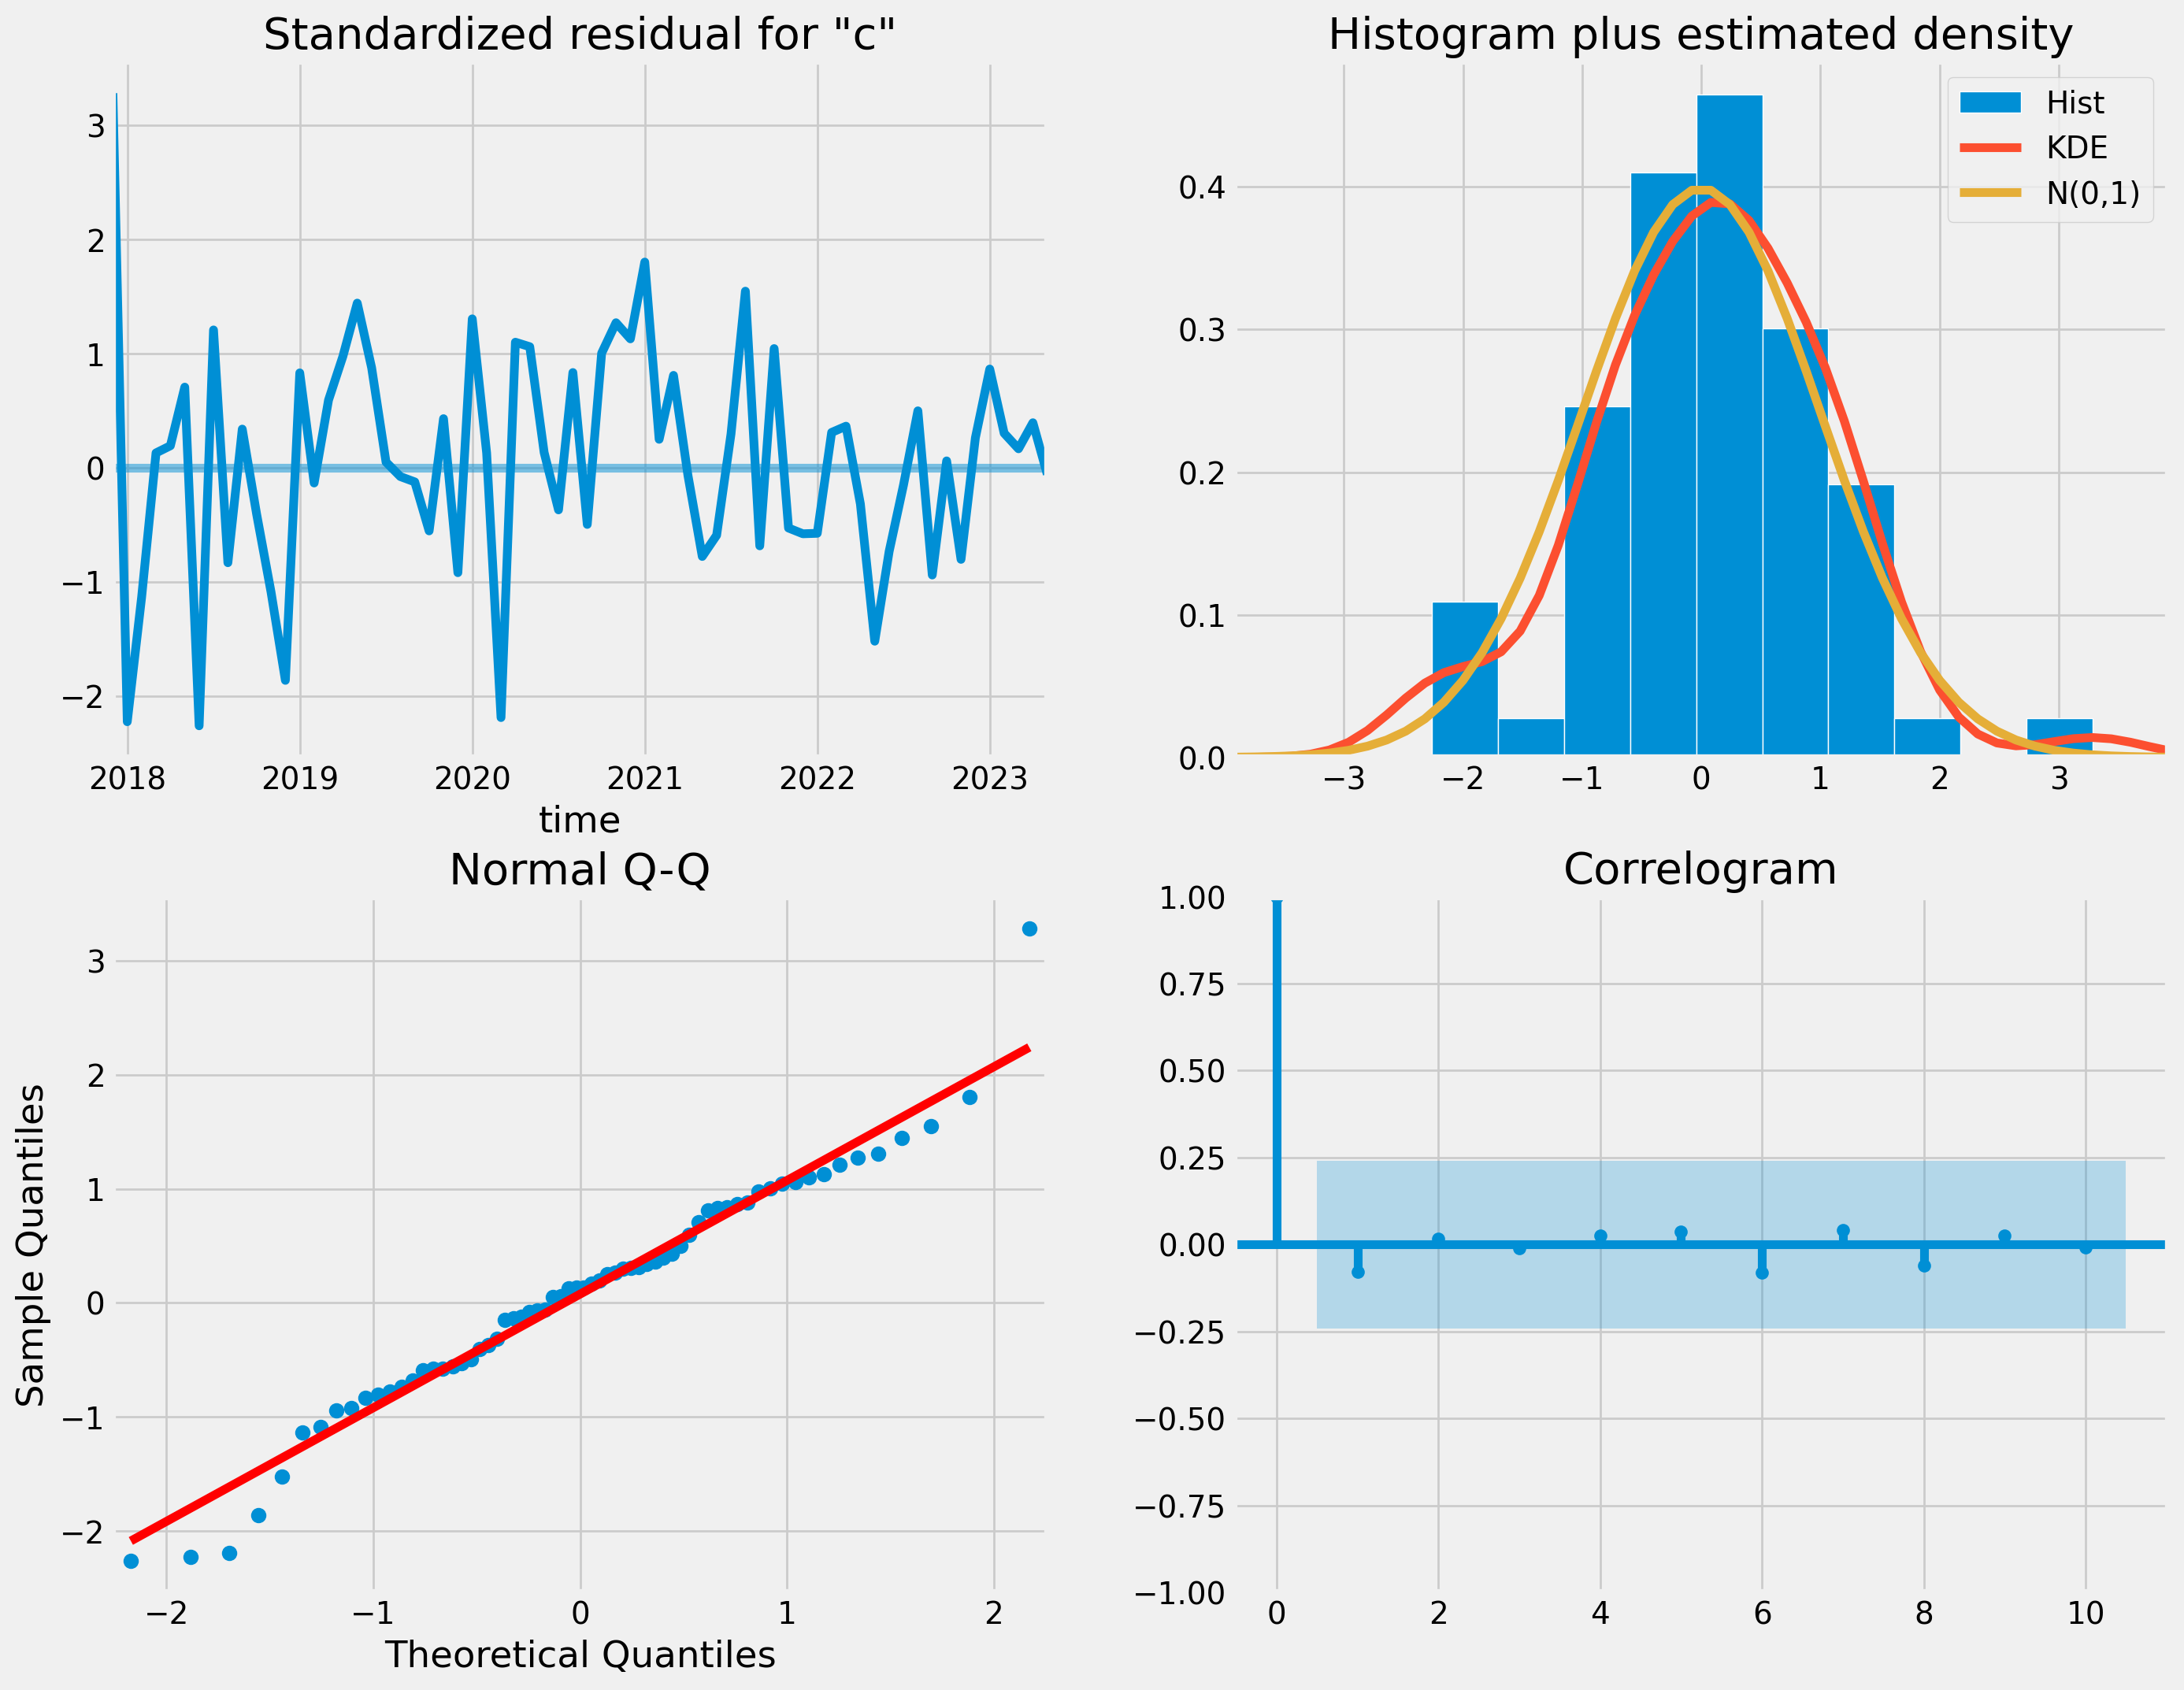

In [ ]:
#running the model diagnostics functions and plotting its result [3]
result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
#using inverse Box-Cox transformation function[3]
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

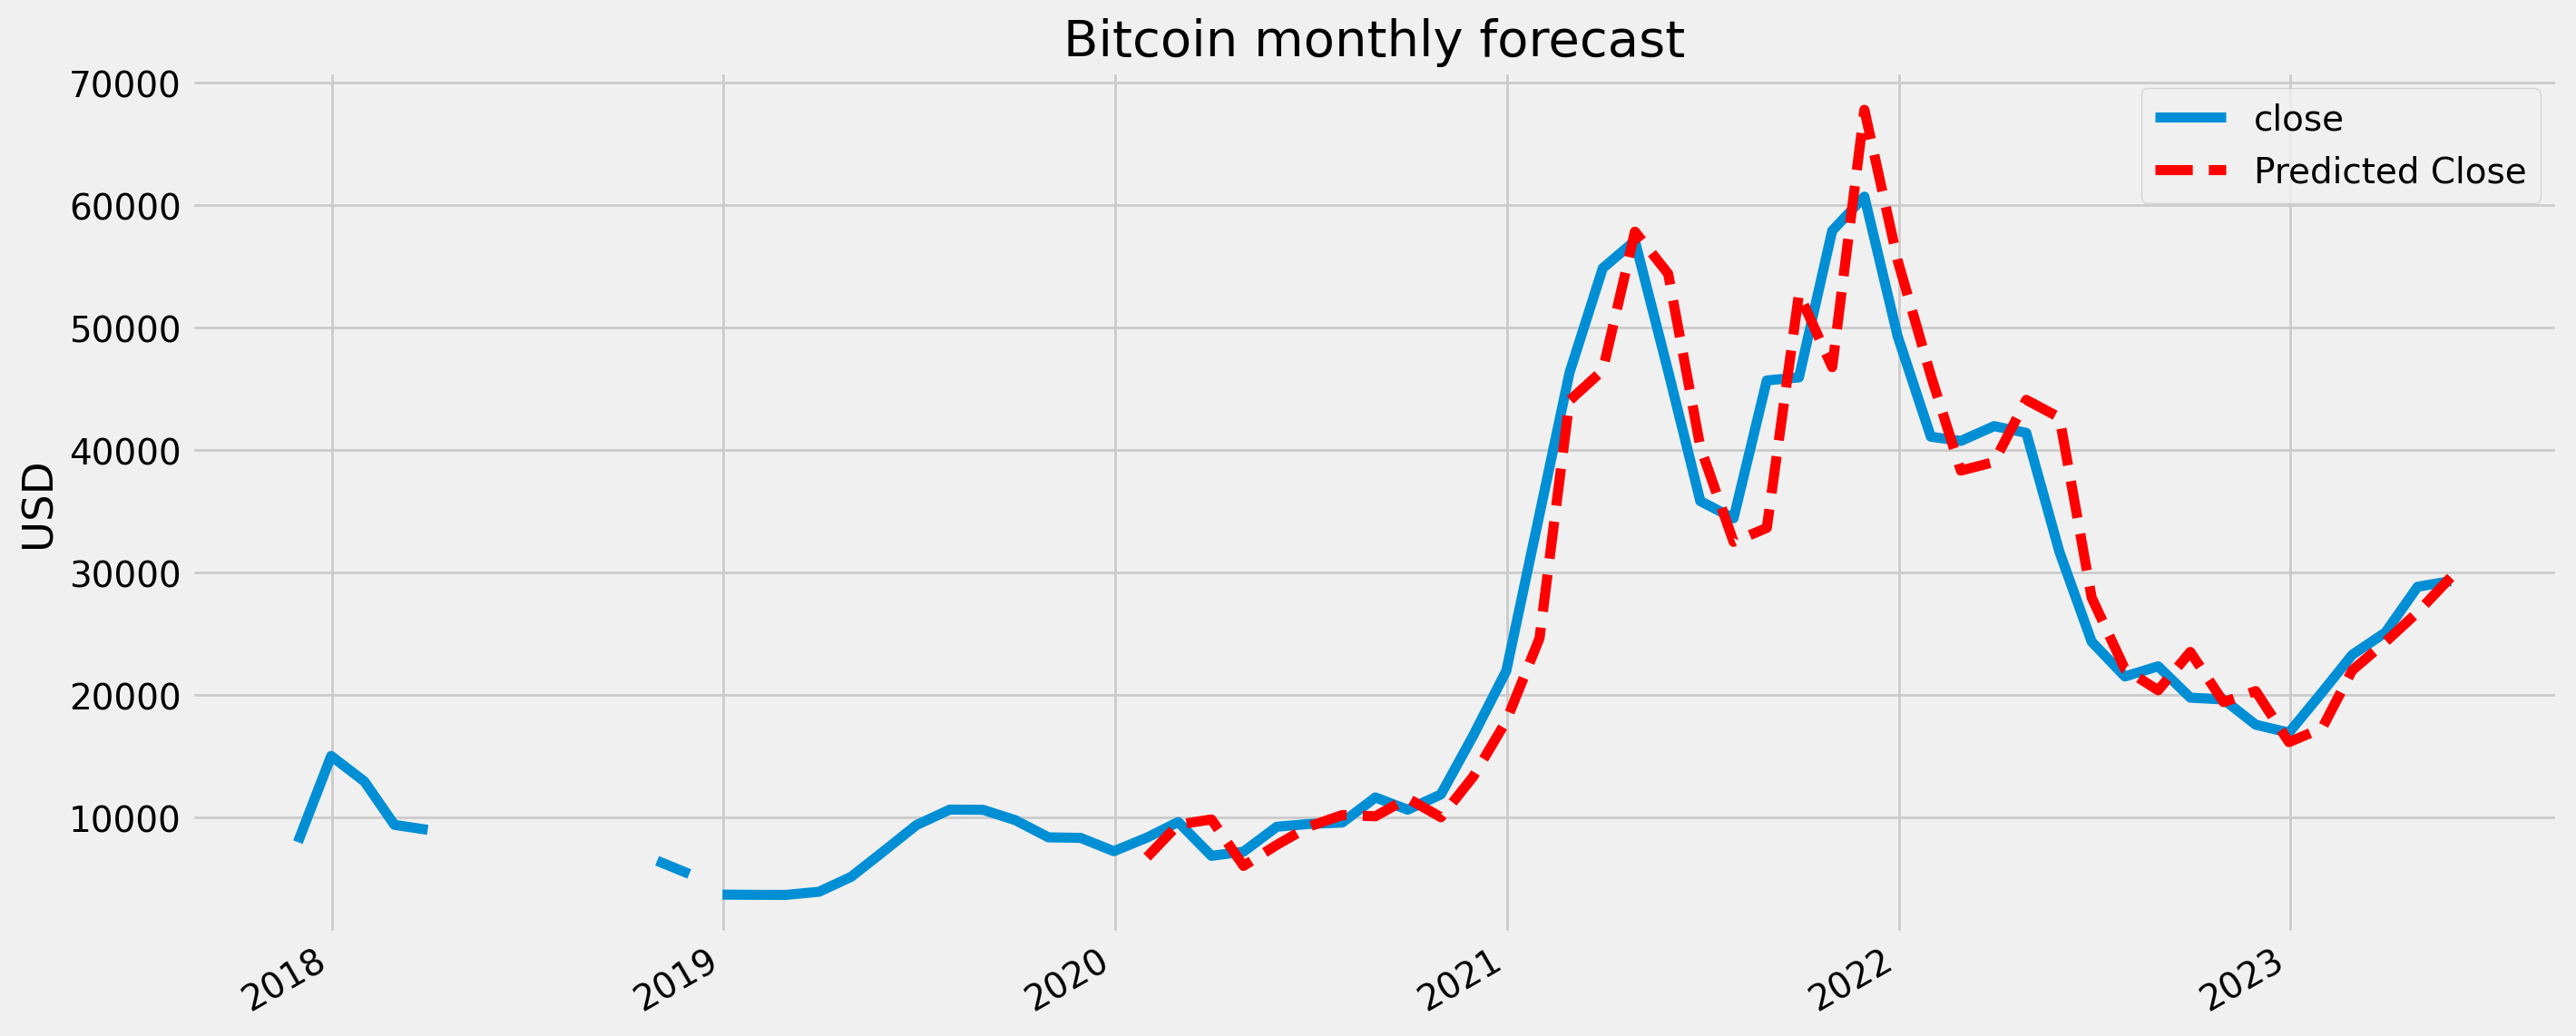

In [ ]:
# predicting prices of Bitcoin's close values[3]
#storing the predictions into a new dataframe
df_mth_pred = df_mth[['close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
             datetime(2018, 11, 30), datetime(2018, 12, 31)]
#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= df_mth.columns)
df_mth_pred = pd.concat([df_mth_pred, future])

#monthly forecasting of the values of Bitcoin's close prices
df_mth_pred['forecast'] = invboxcox(result.predict(start=datetime(2020, 1, 31), end=datetime(2023, 12, 30)), lmbda)

plt.figure(figsize=(15,7))
df_mth_pred.close.plot()
df_mth_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

In [ ]:
df2=df_mth_pred[['close','forecast']].dropna()

In [ ]:
df2

,close,forecast
2020-01-31,8373.643226,6776.051816
2020-02-29,9641.877931,9434.243915
2020-03-31,6882.440323,9850.829516
2020-04-30,7224.177000,6059.685404
2020-05-31,9257.690968,7774.694099
2020-06-30,9481.462667,9271.221157
2020-07-31,9598.915161,10209.926832
2020-08-31,11648.246774,10111.533588
2020-09-30,10647.665333,11583.148000
2020-10-31,11893.398065,10031.059380


In [41]:
#computing RMSE values[1]
#storing the forecasts into new variable
y_forecastd = df2.forecast
#storing the actual close price values
y_truth = df2['2019-01-01':'2023-04-30'].close

# implementing the root mean square error
rmse = np.sqrt(((y_forecastd - df2.close)**2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 4788.8


In [37]:
from sklearn.metrics import explained_variance_score

In [40]:
expl_dt = explained_variance_score(y_forecastd,df2.close)
print(expl_dt)

0.9162424232891223
